Test estimation amlpitudes and decorrelation timescales for different forms of analytical autocorrelations

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

In [2]:
import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
om = 2 # tidal frequency (M2)

def fit_classical(tau,Tt,Vt_ns,Vt_s,Tb,Vb,Omega):
    return (Vt_s+Vt_ns*np.exp(-tau/Tt))*np.cos(2*np.pi*om*tau)+Vb*np.exp(-tau/Tb)*np.cos(2*np.pi*Omega*tau)
def fit_omega(tau,Tt,Vt_ns,Vt_s,Tb,Vb):
    return (Vt_s+Vt_ns*np.exp(-tau/Tt))*np.cos(2*np.pi*om*tau)+Vb*np.exp(-tau/Tb)

def fit_alpha(tau,Tt,Vt,alpha,Tb,Vb):
    return Vt*(alpha+(1-alpha)*np.exp(-tau/Tt))*np.cos(2*np.pi*om*tau)+Vb*np.exp(-tau/Tb)

In [5]:
def fit_v2(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0)),
                     'error' : (['ybin','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [6]:
wp = 8
root_path = '/home/datawork-lops-osi/equinox/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp%s_m1a1_4km_500a1000j/'%str(wp)
#path = root_path+run+'diagnostics/' #datarmor
path = '/Users/zcaspar/codes/Diagnostics2/'
# Autocorrelatoin from data
corrE = xr.open_dataset(path+'wp%s/'%str(wp)+'ZC_Eulerian_corr_80avg1d.nc').rename({'lags':'lag'})
corrL = xr.open_dataset(path+'wp%s/'%str(wp)+'ZC_drifters_corr_80avg1d.nc')
#path = '/Users/zcaspar/codes/Diagnostics/'+run#local

In [12]:
for v in ['uu','vv']:
    corrE[v+'_normalized'] = corrE[v]/corrE[v].sel(lag=0)
    corrL[v+'_normalized'] = corrL[v]/corrL[v].sel(lag=0)
for v in ['uv','vu']:#
    corrE[v+'_normalized'] = corrE[v]/np.sqrt(corrE['uu'].sel(lag=0)*corrE['vv'].sel(lag=0))
    corrL[v+'_normalized'] = corrL[v]/np.sqrt(corrL['uu'].sel(lag=0)*corrL['vv'].sel(lag=0))



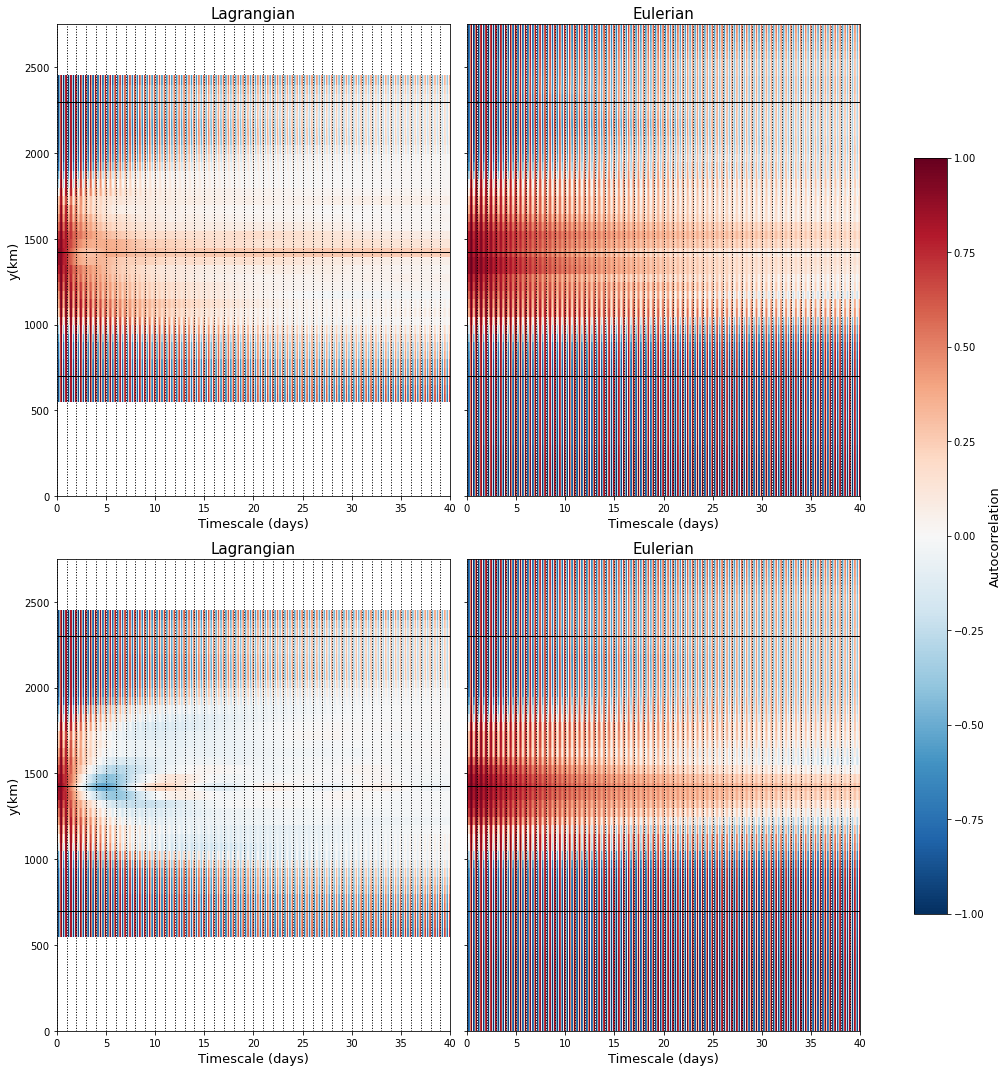

In [8]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
for V,i in zip(['uu','vv'],range(2)):
    im = corrL[V+'_normalized'].plot(ax=ax[i,0],add_colorbar=False);ax[i,0].set_ylabel('')
    corrE[V+'_normalized'].plot(ax=ax[i,1],add_colorbar=False);ax[i,1].set_ylabel('')
    [ax[i,0].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,40,2*0.5)]
    ax[i,0].set_title('Lagrangian',fontsize=15);ax[i,0].set_ylabel('y(km)',fontsize=13);
    ax[i,0].set_xlabel('Timescale (days)',fontsize=13)
    [ax[i,1].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,40,2*0.5)]
    ax[i,1].set_title('Eulerian',fontsize=15);ax[i,1].set_yticklabels('')#;ax[i,1].set_ylabel('y(m)',fontsize=15)
    ax[i,1].set_xlabel('Timescale (days)',fontsize=13)
    for y in [700,1425,2300]:
        ax[i,0].axhline(y,c='k',linewidth=1)
        ax[i,1].axhline(y*1e3,c='k',linewidth=1)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Autocorrelation',size=13)

In [8]:
from inspect import signature
import scipy


# Parameters
myfunc = fit_classical #function to use for the fit
bounds = ((1,0,0,2,0,0),(40,np.inf,np.inf,2000,np.inf,1)) # bounds for the fit to avoid non physical results
bounds_E = ((1,0,0,0,0,0),(40,np.inf,np.inf,2000,np.inf,1))
ce,cl = 'lightseagreen','firebrick'

In [10]:
fit_L,fit_E = {},{}
for V in ['uu','vv'] :
    fit_L[V] = xr.concat([fit_v2(corrL[V].lag,
                                      corrL[V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL[V].y_bins],dim='ybin')
    fit_E[V] = xr.concat([fit_v2(corrE[V].lag,
                                      corrE[V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE[V].y_bins],dim='ybin')

    fit_E[V] = fit_E[V].assign_coords({'ybin':fit_E[V].ybin.values*1e-3})
    fit_E[V+'_normalized'] = fit_E[V].fitted/fit_E[V].fitted.sel(lags=0)
    fit_L[V+'_normalized'] = fit_L[V].fitted/fit_L[V].fitted.sel(lags=0)

In [11]:
# Parameters
myfunc = fit_omega #function to use for the fit
bounds = ((1,0,0,2,0),(40,np.inf,np.inf,2000,np.inf)) # bounds for the fit to avoid non physical results
bounds_E = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf))

In [12]:
fit_L_omega,fit_E_omega = {},{}
for V in ['uu','vv'] :
    fit_L_omega[V] = xr.concat([fit_v2(corrL[V].lag,
                                      corrL[V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL[V].y_bins],dim='ybin')
    fit_E_omega[V] = xr.concat([fit_v2(corrE[V].lag,
                                      corrE[V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE[V].y_bins],dim='ybin')

    fit_E_omega[V] = fit_E_omega[V].assign_coords({'ybin':fit_E_omega[V].ybin.values*1e-3})
    fit_E_omega[V+'_normalized'] = fit_E_omega[V].fitted/fit_E_omega[V].fitted.sel(lags=0)
    fit_L_omega[V+'_normalized'] = fit_L_omega[V].fitted/fit_L_omega[V].fitted.sel(lags=0)

In [9]:
# Parameters
myfunc = fit_alpha #function to use for the fit
bounds = ((1,0,0,2,0),(40,np.inf,np.inf,2000,np.inf)) # bounds for the fit to avoid non physical results
bounds_E = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf))

In [10]:
fit_L_alpha,fit_E_alpha = {},{}
for V in ['uu','vv'] :
    fit_L_alpha[V] = xr.concat([fit_v2(corrL[V].lag,
                                      corrL[V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL[V].y_bins],dim='ybin')
    fit_E_alpha[V] = xr.concat([fit_v2(corrE[V].lag,
                                      corrE[V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE[V].y_bins],dim='ybin')

    fit_E_alpha[V] = fit_E_alpha[V].assign_coords({'ybin':fit_E_alpha[V].ybin.values*1e-3})
    fit_E_alpha[V+'_normalized'] = fit_E_alpha[V].fitted/fit_E_alpha[V].fitted.sel(lags=0)
    fit_L_alpha[V+'_normalized'] = fit_L_alpha[V].fitted/fit_L_alpha[V].fitted.sel(lags=0)

    

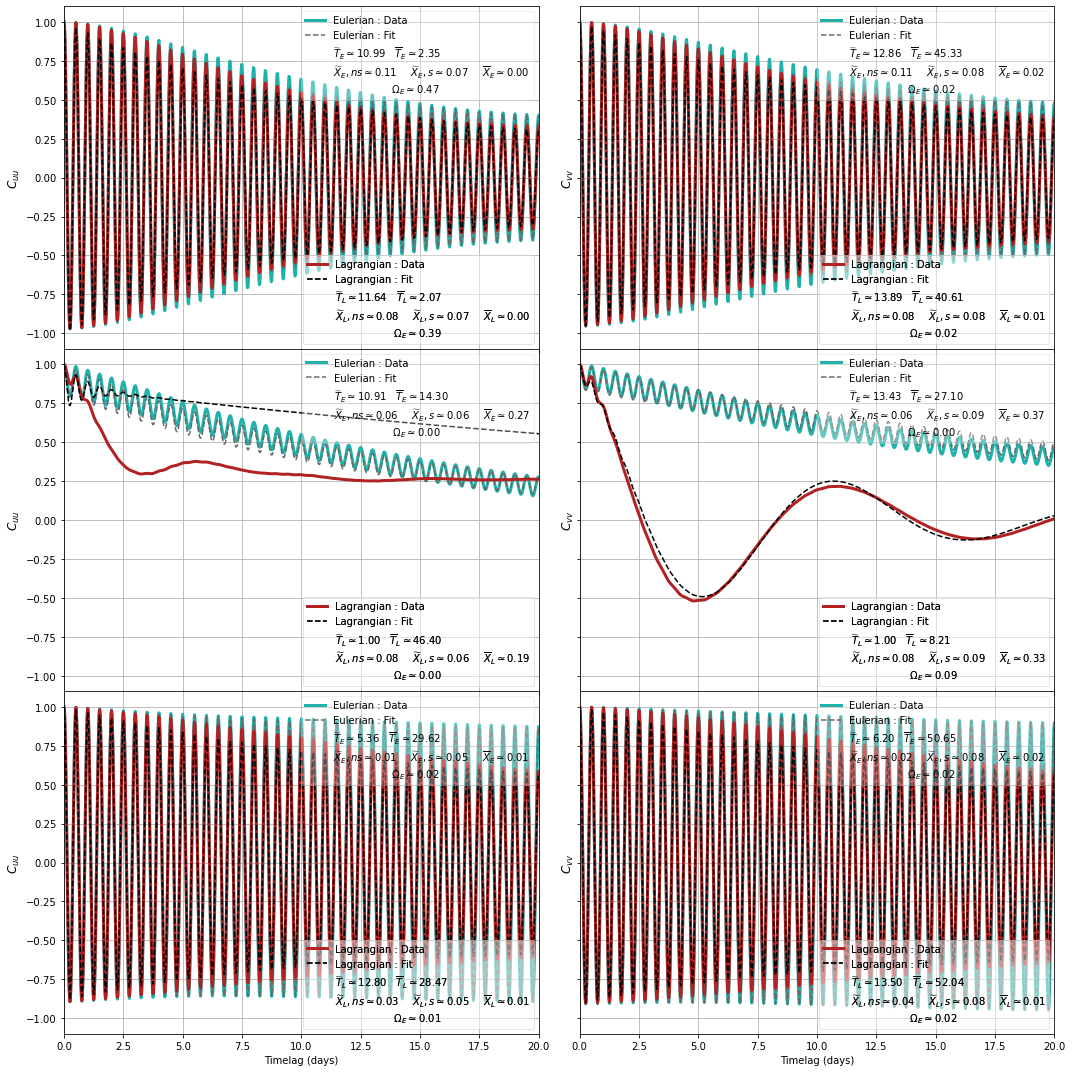

In [15]:
import matplotlib as mpl
from matplotlib.patches import Rectangle

ce_fit = 'dimgrey'
cl_fit='k'#'silver'
#Sections
Y=[2300,1425,700]

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

# place a text box in upper left in axes coords


fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        paE = fit_E[V].sel(ybin=y,method='nearest').params.values
        paL = fit_L[V].sel(ybin=y,method='nearest').params.values
        textstrE = '\n'.join((
            r'$\widetilde{T}_E\simeq%.2f\hspace{1}\overline{T}_E\simeq%.2f$' % (paE[0], paE[3]),
            r'$\widetilde{X}_E,ns\simeq%.2f\hspace{1.5}\widetilde{X}_E,s\simeq%.2f\hspace{1.5}\overline{X}_E\simeq%.2f$' % (np.sqrt(paE[1]),np.sqrt(paE[2]),np.sqrt(paE[4])),
            r'$\hspace{6}\Omega_E\simeq%.2f$'% (paE[5],)
                            ))
        textstrL = '\n'.join((
            r'$\widetilde{T}_L\simeq%.2f\hspace{1}\overline{T}_L\simeq%.2f$' % (paL[0], paL[3]),
            r'$\widetilde{X}_L,ns\simeq%.2f\hspace{1.5}\widetilde{X}_L,s\simeq%.2f\hspace{1.5}\overline{X}_L\simeq%.2f$' % (np.sqrt(paL[1]),np.sqrt(paE[2]),np.sqrt(paL[4])),
            r'$\hspace{6}\Omega_E\simeq%.2f$'% (paL[5],)
                            ))
        corrE[V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,linewidth = 3,ax=ax,label=('Eulerian : Data'))
   
        fit_E[V+'_normalized'].sel(ybin=y,method='nearest').plot(c = ce_fit,linestyle='--',ax=ax,label=('Eulerian : Fit'))
        corrL[V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,linewidth = 3,ax=ax,label=('Lagrangian : Data'))
        fit_L[V+'_normalized'].sel(ybin=y,method='nearest').plot(c=cl_fit,linestyle='--',ax=ax,label=('Lagrangian : Fit'))
        handles,labels = ax.get_legend_handles_labels()
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        legendE = ax.legend(handles[:2]+[extra],labels[:2]+[textstrE],loc='upper right',framealpha=0.3);
        ax.add_artist(legendE)
        legendL = ax.legend(handles[2:]+[extra],labels[2:]+[textstrL],loc='lower right',framealpha=0.3)
        ax.add_artist(legendL)
        ax.set_ylim(-1.1,1.1);ax.grid();ax.set_title('')
        ax.set_ylabel(r'$C_{%s}$'%V,fontsize=12);ax.set_xlabel('Timelag (days)')
        ax.set_xlim(0,20)
    fig.tight_layout()
#fig.savefig('/home1/datawork/zcaspar/Fig_paper/sections_fit_20v2.pdf')

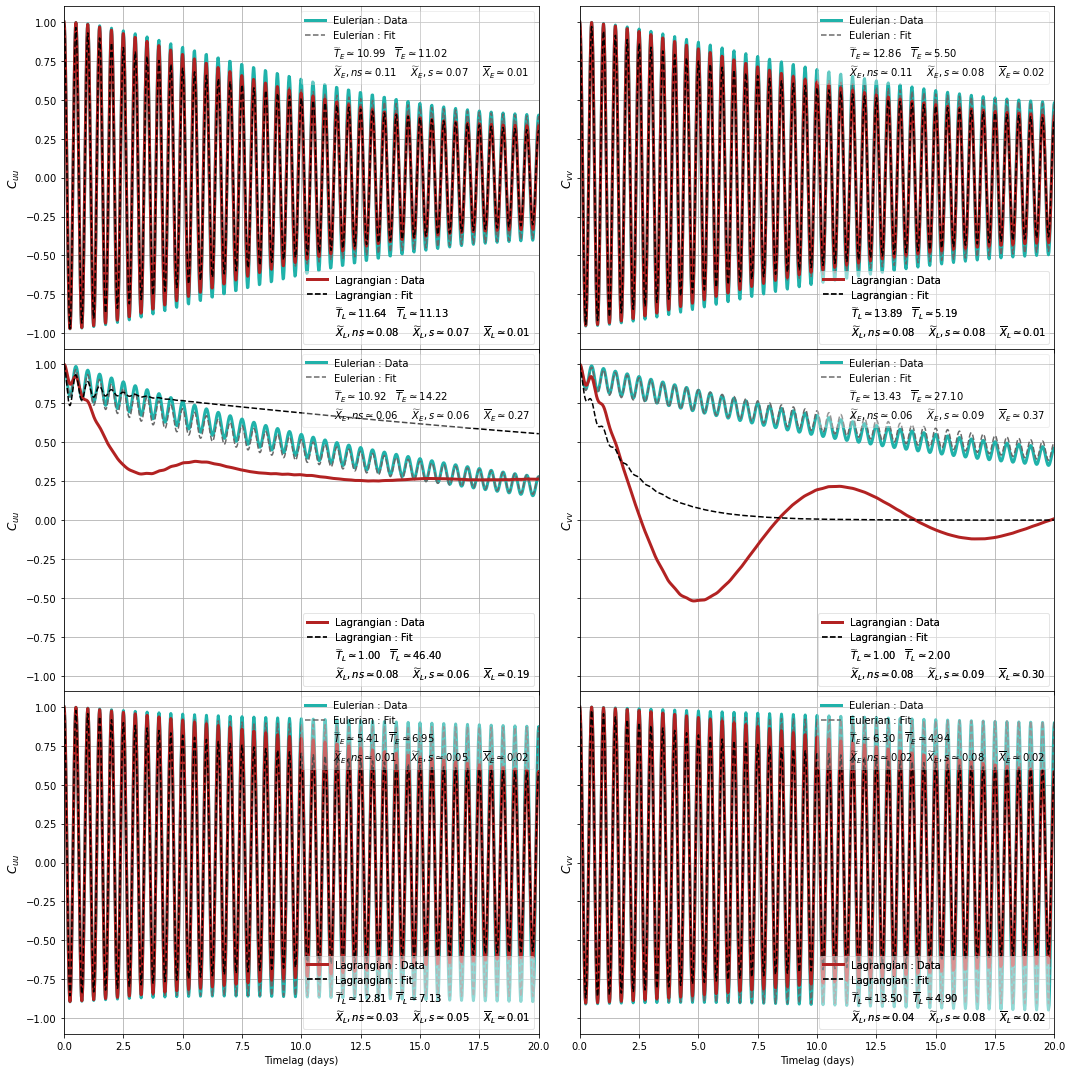

In [16]:
fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        paE = fit_E_omega[V].sel(ybin=y,method='nearest').params.values
        paL = fit_L_omega[V].sel(ybin=y,method='nearest').params.values
        textstrE = '\n'.join((
            r'$\widetilde{T}_E\simeq%.2f\hspace{1}\overline{T}_E\simeq%.2f$' % (paE[0], paE[3]),
            r'$\widetilde{X}_E,ns\simeq%.2f\hspace{1.5}\widetilde{X}_E,s\simeq%.2f\hspace{1.5}\overline{X}_E\simeq%.2f$' % (np.sqrt(paE[1]),np.sqrt(paE[2]),np.sqrt(paE[4]))
                            ))
        textstrL = '\n'.join((
            r'$\widetilde{T}_L\simeq%.2f\hspace{1}\overline{T}_L\simeq%.2f$' % (paL[0], paL[3]),
            r'$\widetilde{X}_L,ns\simeq%.2f\hspace{1.5}\widetilde{X}_L,s\simeq%.2f\hspace{1.5}\overline{X}_L\simeq%.2f$' % (np.sqrt(paL[1]),np.sqrt(paE[2]),np.sqrt(paL[4]))
            ))
        corrE[V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,linewidth = 3,ax=ax,label=('Eulerian : Data'))
   
        fit_E_omega[V+'_normalized'].sel(ybin=y,method='nearest').plot(c = ce_fit,linestyle='--',ax=ax,label=('Eulerian : Fit'))
        corrL[V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,linewidth = 3,ax=ax,label=('Lagrangian : Data'))
        fit_L_omega[V+'_normalized'].sel(ybin=y,method='nearest').plot(c=cl_fit,linestyle='--',ax=ax,label=('Lagrangian : Fit'))
        handles,labels = ax.get_legend_handles_labels()
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        legendE = ax.legend(handles[:2]+[extra],labels[:2]+[textstrE],loc='upper right',framealpha=0.3);
        ax.add_artist(legendE)
        legendL = ax.legend(handles[2:]+[extra],labels[2:]+[textstrL],loc='lower right',framealpha=0.3)
        ax.add_artist(legendL)
        ax.set_ylim(-1.1,1.1);ax.grid();ax.set_title('')
        ax.set_ylabel(r'$C_{%s}$'%V,fontsize=12);ax.set_xlabel('Timelag (days)')
        ax.set_xlim(0,20)
    fig.tight_layout()
#fig.savefig('/home1/datawork/zcaspar/Fig_paper/sections_fit_20v2.pdf')

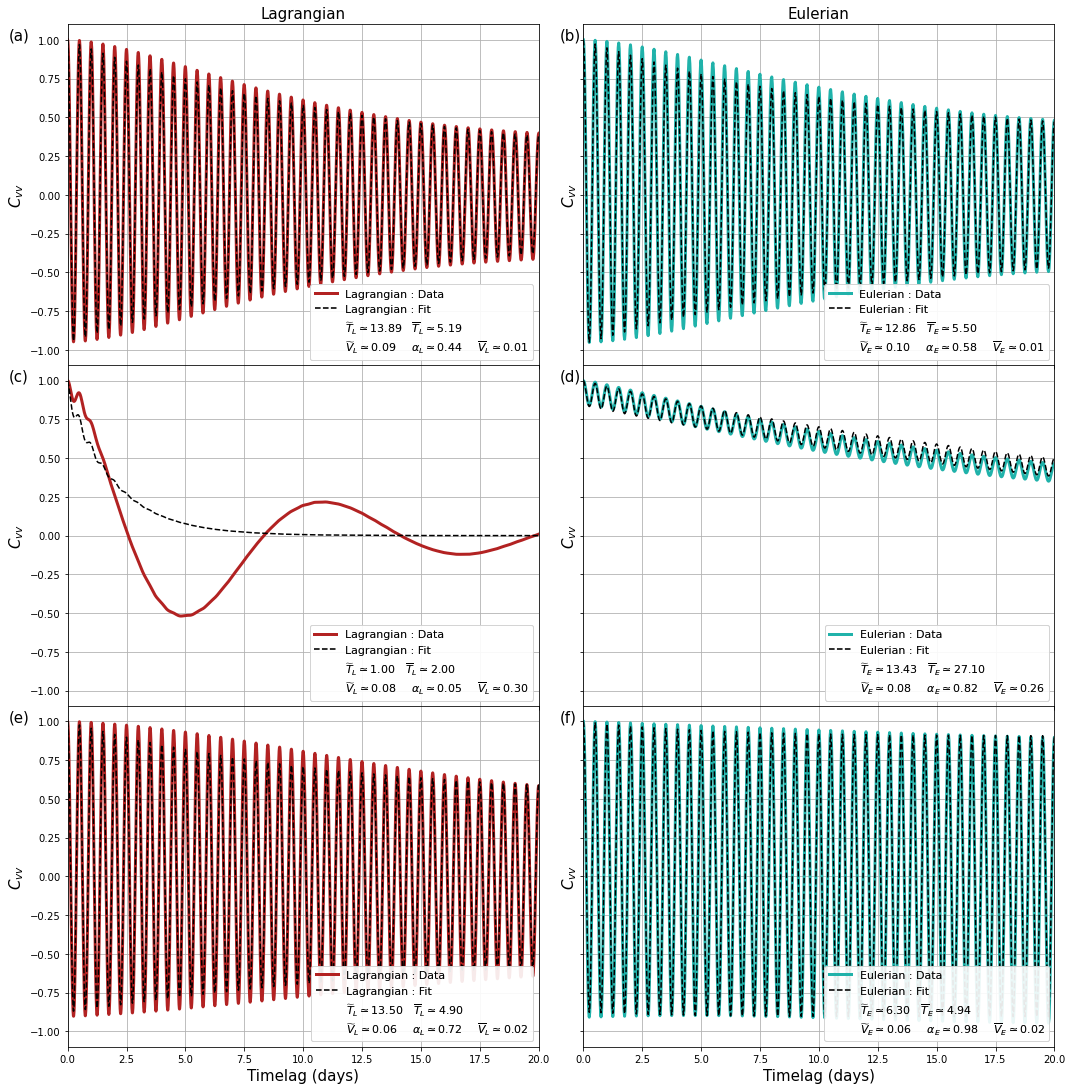

In [16]:
# Figure 4 review 2
import matplotlib as mpl
from matplotlib.patches import Rectangle

ce_fit = 'k'
cl_fit='k'
#Sections
Y=[2300,1425,700]

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

# place a text box in upper left in axes coords


fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
V = 'vv'
for i,y in enumerate(Y):
    paE = fit_E_alpha[V].sel(ybin=y,method='nearest').params.values
    paL = fit_L_alpha[V].sel(ybin=y,method='nearest').params.values
    textstrE = '\n'.join((
            r'$\widetilde{T}_E\simeq%.2f\hspace{1}\overline{T}_E\simeq%.2f$' % (paE[0], paE[3]),
            r'$\widetilde{V}_E\simeq%.2f\hspace{1.5}\alpha_E\simeq%.2f\hspace{1.5}\overline{V}_E\simeq%.2f$' % (np.sqrt(paE[1]/2),np.sqrt(paE[2]),np.sqrt(paE[4]/2))
                            ))
    textstrL = '\n'.join((
            r'$\widetilde{T}_L\simeq%.2f\hspace{1}\overline{T}_L\simeq%.2f$' % (paL[0], paL[3]),
            r'$\widetilde{V}_L\simeq%.2f\hspace{1.5}\alpha_L\simeq%.2f\hspace{1.5}\overline{V}_L\simeq%.2f$' % (np.sqrt(paL[1]),np.sqrt(paL[2]),np.sqrt(paL[4]))
            ))
    corrE[V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,linewidth = 3,ax=axs[i,1],label=('Eulerian : Data'))
    fit_E_alpha[V+'_normalized'].sel(ybin=y,method='nearest').plot(c = ce_fit,linestyle='--',ax=axs[i,1],label=('Eulerian : Fit'))
    corrL[V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,linewidth = 3,ax=axs[i,0],label=('Lagrangian : Data'))
    fit_L_alpha[V+'_normalized'].sel(ybin=y,method='nearest').plot(c=cl_fit,linestyle='--',ax=axs[i,0],label=('Lagrangian : Fit'))
    handles,labels = axs[i,0].get_legend_handles_labels()
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    legendL = axs[i,0].legend(handles[:]+[extra],labels[:]+[textstrL],loc='lower right',framealpha=0.7,fontsize=11)
    axs[i,0].add_artist(legendL)
    handles,labels = axs[i,1].get_legend_handles_labels()
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    legendE = axs[i,1].legend(handles[:]+[extra],labels[:]+[textstrE],loc='lower right',framealpha=0.7,fontsize=11);
    axs[i,1].add_artist(legendE)
    for ax in axs[i,:]:
        ax.set_ylim(-1.1,1.1);ax.grid();ax.set_title('')
        ax.set_ylabel(r'$C_{%s}$'%V,fontsize=15);ax.set_xlabel('Timelag (days)',fontsize=15)
        ax.set_xlim(0,20)
        
fig.tight_layout()
for ax,txt in zip(axs[:,0],['(a)','(c)','(e)']):
    ax.text(-2.5,1,txt,fontsize=15)
for ax,txt in zip(axs[:,1],['(b)','(d)','(f)']):
    ax.text(-1.,1,txt,fontsize=15)
axs[0,0].set_title('Lagrangian',fontsize=15)
axs[0,1].set_title('Eulerian',fontsize=15)

fig.savefig('/Users/zcaspar/Documents/Figures/Figures_paper/Figure4_review2.pdf',bbox_inches='tight')

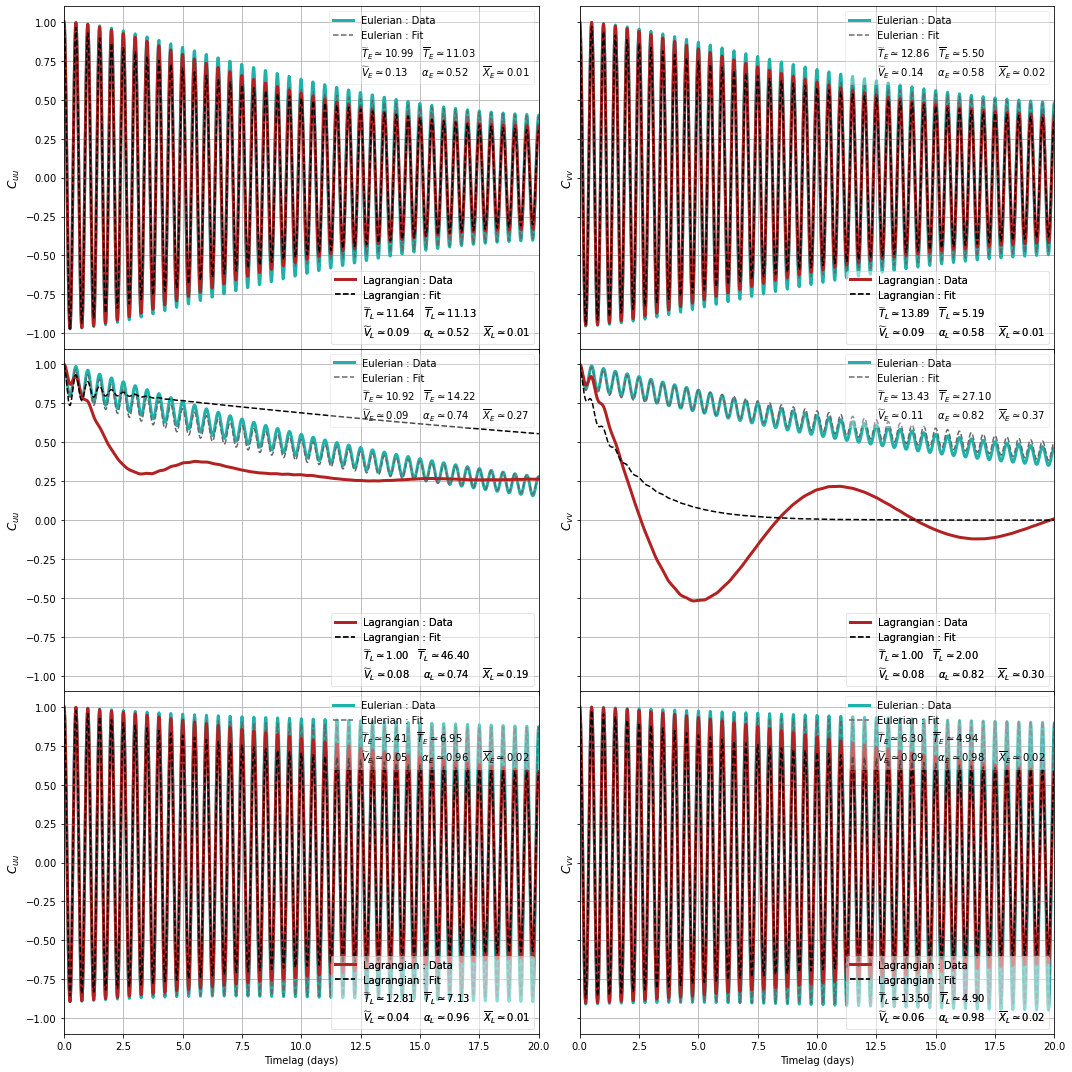

In [17]:
fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        paE = fit_E_alpha[V].sel(ybin=y,method='nearest').params.values
        paL = fit_L_alpha[V].sel(ybin=y,method='nearest').params.values
        textstrE = '\n'.join((
            r'$\widetilde{T}_E\simeq%.2f\hspace{1}\overline{T}_E\simeq%.2f$' % (paE[0], paE[3]),
            r'$\widetilde{V}_E\simeq%.2f\hspace{1.5}\alpha_E\simeq%.2f\hspace{1.5}\overline{X}_E\simeq%.2f$' % (np.sqrt(paE[1]),np.sqrt(paE[2]),np.sqrt(paE[4]))
                            ))
        textstrL = '\n'.join((
            r'$\widetilde{T}_L\simeq%.2f\hspace{1}\overline{T}_L\simeq%.2f$' % (paL[0], paL[3]),
            r'$\widetilde{V}_L\simeq%.2f\hspace{1.5}\alpha_L\simeq%.2f\hspace{1.5}\overline{X}_L\simeq%.2f$' % (np.sqrt(paL[1]),np.sqrt(paE[2]),np.sqrt(paL[4]))
            ))
        corrE[V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,linewidth = 3,ax=ax,label=('Eulerian : Data'))
   
        fit_E_alpha[V+'_normalized'].sel(ybin=y,method='nearest').plot(c = ce_fit,linestyle='--',ax=ax,label=('Eulerian : Fit'))
        corrL[V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,linewidth = 3,ax=ax,label=('Lagrangian : Data'))
        fit_L_alpha[V+'_normalized'].sel(ybin=y,method='nearest').plot(c=cl_fit,linestyle='--',ax=ax,label=('Lagrangian : Fit'))
        handles,labels = ax.get_legend_handles_labels()
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        legendE = ax.legend(handles[:2]+[extra],labels[:2]+[textstrE],loc='upper right',framealpha=0.3);
        ax.add_artist(legendE)
        legendL = ax.legend(handles[2:]+[extra],labels[2:]+[textstrL],loc='lower right',framealpha=0.3)
        ax.add_artist(legendL)
        ax.set_ylim(-1.1,1.1);ax.grid();ax.set_title('')
        ax.set_ylabel(r'$C_{%s}$'%V,fontsize=12);ax.set_xlabel('Timelag (days)')
        ax.set_xlim(0,20)
    fig.tight_layout()


In [18]:
lims_uu = [(0,40),(0,40),(-0.01,0.05),(0,0.2),(0,0.2),(0,0.4)]
lims_vv = [(0,40),(0,40),(-0.01,0.05),(0,0.2),(0,0.2),(0,0.4)]
titles = [r'$\widetilde{T}$',r'$\overline{T}$',r'$\Omega$',r'$\widetilde{V}_{ns}$',r'$\widetilde{V}_s$',r'$\overline{V}$']

Text(0.5, 0.98, 'Autocorrelation of u')

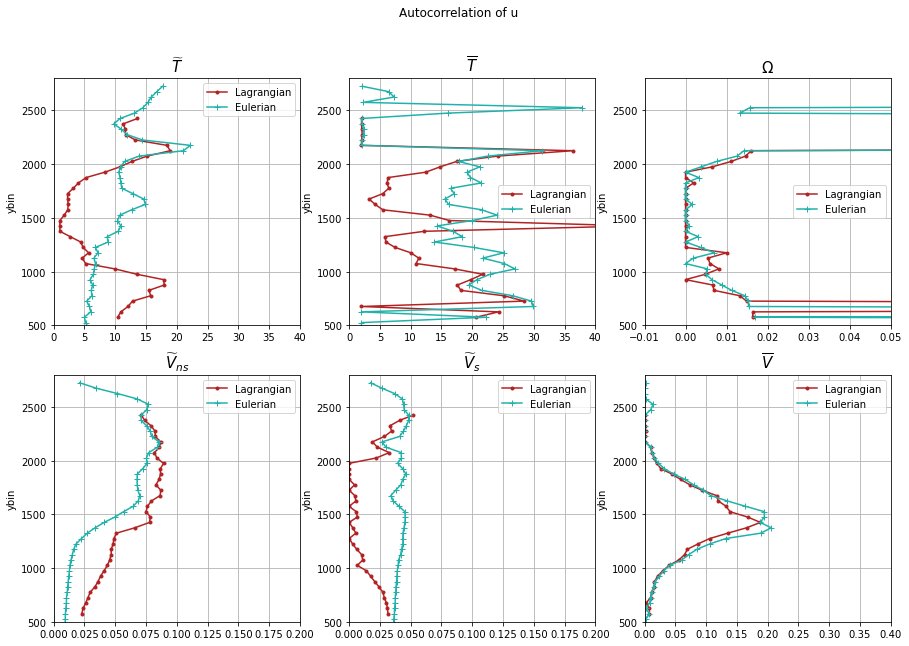

In [19]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb','Omega'],titles[:3],lims_uu[:3],axes[0,:]):
    fit_L['uu'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    fit_E['uu'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Vt_ns','Vt_s','Vb'],titles[3:],lims_uu[3:],axes[1,:]):
    np.sqrt(fit_L['uu'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(fit_E['uu'].params.sel(param=pa)/2).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of u')


Text(0.5, 0.98, 'Autocorrelation of v')

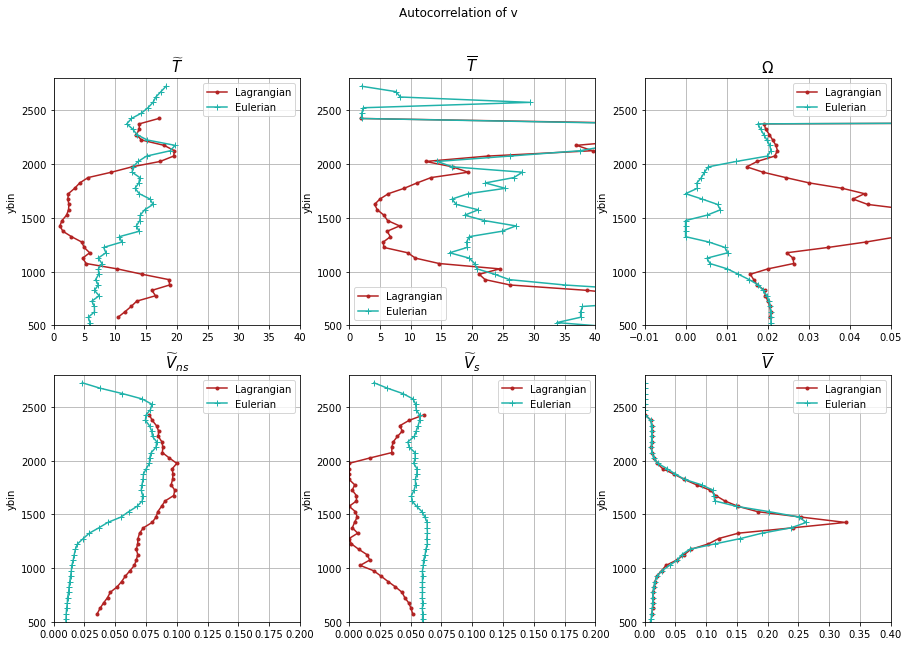

In [20]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb','Omega'],titles[:3],lims_vv[:3],axes[0,:]):
    fit_L['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    fit_E['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Vt_ns','Vt_s','Vb'],titles[3:],lims_vv[3:],axes[1,:]):
    np.sqrt(fit_L['vv'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(fit_E['vv'].params.sel(param=pa)/2).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of v')

Text(0.5, 0.98, 'Autocorrelation of v')

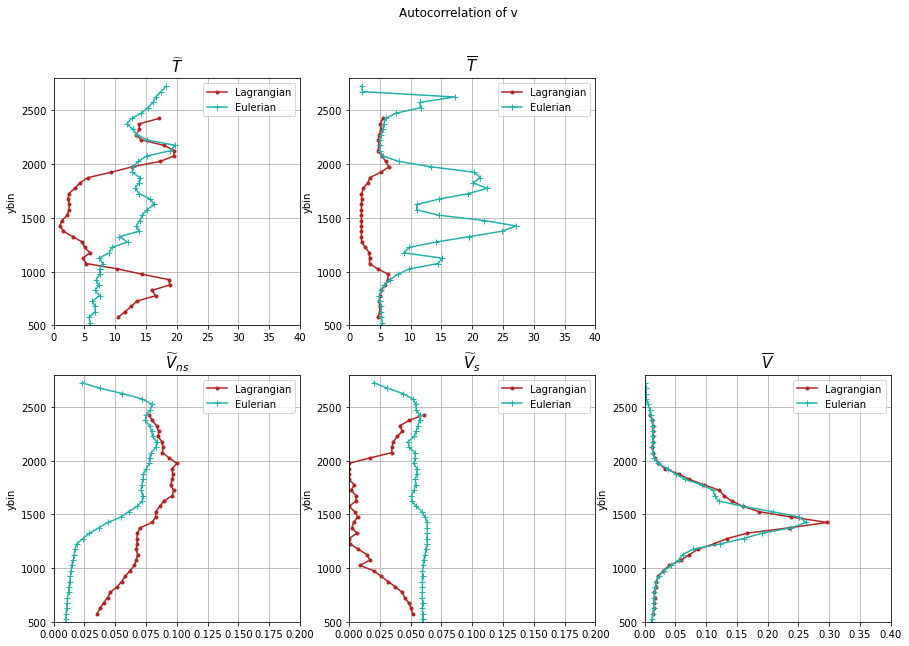

In [21]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:3],lims_vv[:3],axes[0,:]):
    fit_L_omega['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    fit_E_omega['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Vt_ns','Vt_s','Vb'],titles[3:],lims_vv[3:],axes[1,:]):
    np.sqrt(fit_L_omega['vv'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(fit_E_omega['vv'].params.sel(param=pa)/2).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])
fig.suptitle('Autocorrelation of v')

In [22]:
lims_uu = [(0,40),(0,40),(0,0.2),(0,0.4)]
lims_vv = [(0,40),(0,40),(0,0.2),(0,0.4)]
titles = [r'$\widetilde{T}$',r'$\overline{T}$',r'$\widetilde{V}$',r'$\overline{V}$']

Text(0.5, 0.98, 'Autocorrelation of v')

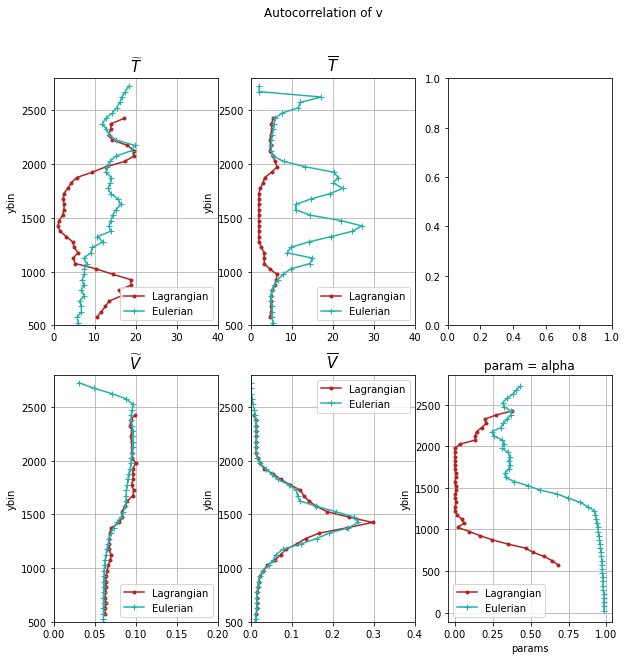

In [23]:
fig,axes = plt.subplots(2,3,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:2],lims_vv[:2],axes[0,:]):
    fit_L_alpha['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    fit_E_alpha['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Vt','Vb'],titles[2:],lims_vv[2:],axes[1,:]):
    np.sqrt(fit_L_alpha['vv'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(fit_E_alpha['vv'].params.sel(param=pa)/2).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fit_L_alpha['vv'].params.sel(param='alpha').plot(y='ybin',c=cl,ax=axes[1,2],marker='.',label='Lagrangian')
(fit_E_alpha['vv'].params.sel(param='alpha')).plot(y='ybin', c=ce,ax=axes[1,2],marker='+',label='Eulerian')
axes[1,2].legend();axes[1,2].grid()

fig.suptitle('Autocorrelation of v')

Text(0.5, 1.0, 'Eulerian total variance')

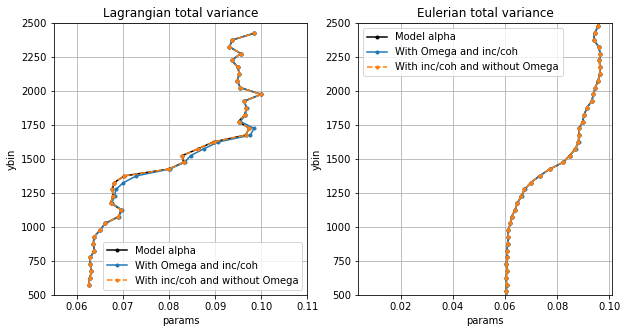

In [24]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
np.sqrt(fit_L_alpha['vv'].params.sel(param='Vt')).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_L['vv'].params.sel(param='Vt_s')+fit_L['vv'].params.sel(param='Vt_ns')).plot(y='ybin',ax=ax,marker='.',label='With Omega and inc/coh')
np.sqrt(fit_L_omega['vv'].params.sel(param='Vt_s')+fit_L_omega['vv'].params.sel(param='Vt_ns')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(0.055,0.11)
ax.set_title('Lagrangian total variance')

ax=axes[1]
np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_E['vv'].params.sel(param='Vt_s')/2+fit_E['vv'].params.sel(param='Vt_ns')/2).plot(y='ybin',ax=ax,marker='.',label='With Omega and inc/coh')
np.sqrt(fit_E_omega['vv'].params.sel(param='Vt_s')/2+fit_E_omega['vv'].params.sel(param='Vt_ns')/2).plot(y='ybin',ax=ax,marker='.',label='With inc/coh and without Omega',linestyle='--')
ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500)#;ax.set_xlim(0.055,0.11)
ax.set_title('Eulerian total variance')

Text(0.5, 1.0, 'Eulerian coherent variance')

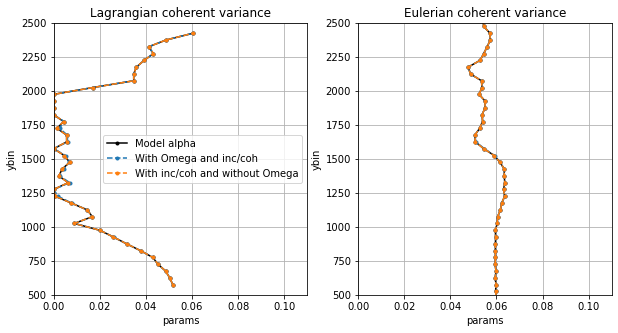

In [25]:
Vt_s_alpha_L = fit_L_alpha['vv'].params.sel(param='Vt')*fit_L_alpha['vv'].params.sel(param='alpha')
Vt_ns_alpha_L = fit_L_alpha['vv'].params.sel(param='Vt')*(1-fit_L_alpha['vv'].params.sel(param='alpha'))

Vt_s_alpha_E = fit_E_alpha['vv'].params.sel(param='Vt')*fit_E_alpha['vv'].params.sel(param='alpha')
Vt_ns_alpha_E = fit_E_alpha['vv'].params.sel(param='Vt')*(1-fit_E_alpha['vv'].params.sel(param='alpha'))

fig,axes = plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
np.sqrt(Vt_s_alpha_L).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_L['vv'].params.sel(param='Vt_s')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
np.sqrt(fit_L_omega['vv'].params.sel(param='Vt_s')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(-0.0,0.11)
ax.set_title('Lagrangian coherent variance')

ax=axes[1]
np.sqrt(Vt_s_alpha_E/2).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_E['vv'].params.sel(param='Vt_s')/2).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
np.sqrt(fit_E_omega['vv'].params.sel(param='Vt_s')/2).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
#ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(-0.0,0.11)
ax.set_title('Eulerian coherent variance')

Text(0.5, 1.0, 'Eulerian incoherent variance')

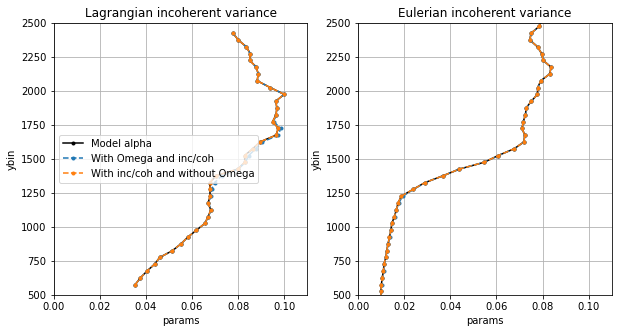

In [26]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
np.sqrt(Vt_ns_alpha_L).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_L['vv'].params.sel(param='Vt_ns')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
np.sqrt(fit_L_omega['vv'].params.sel(param='Vt_ns')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
ax.legend();ax.set_ylim(500,2500);ax.set_xlim(0.0,0.11)
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid()
ax.set_title('Lagrangian incoherent variance')
ax=axes[1]
np.sqrt(Vt_ns_alpha_E/2).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_E['vv'].params.sel(param='Vt_ns')/2).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
np.sqrt(fit_E_omega['vv'].params.sel(param='Vt_ns')/2).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
#ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(0.0,0.11)
ax.set_title('Eulerian incoherent variance')

Text(0.5, 1.0, 'Eulerian incoherence timescale')

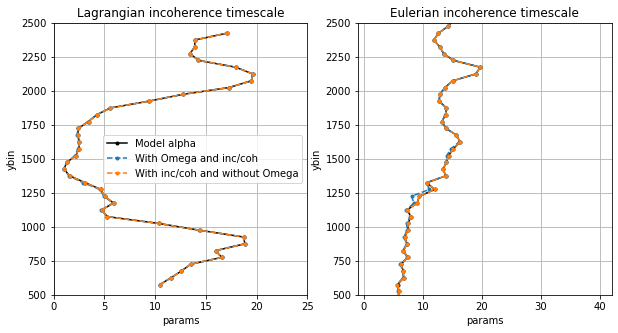

In [27]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
fit_L_alpha['vv'].params.sel(param='Tt').plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
fit_L['vv'].params.sel(param='Tt').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
fit_L_omega['vv'].params.sel(param='Tt').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(0.0,25)
ax.set_title('Lagrangian incoherence timescale')

ax=axes[1]
fit_E_alpha['vv'].params.sel(param='Tt').plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
fit_E['vv'].params.sel(param='Tt').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
fit_E_omega['vv'].params.sel(param='Tt').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
#ax.legend(loc=5)
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500)#;ax.set_xlim(0.0,25)
ax.set_title('Eulerian incoherence timescale')

Text(0.5, 1.0, 'Eulerian slow amplitude')

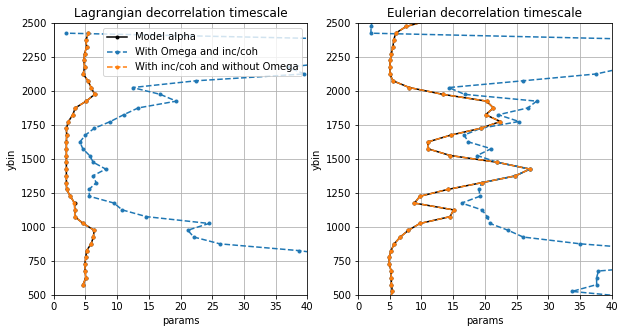

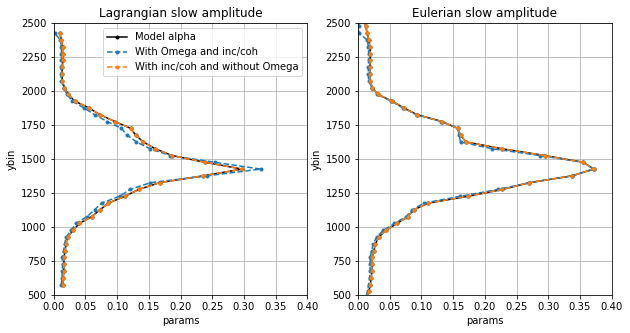

In [28]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
fit_L_alpha['vv'].params.sel(param='Tb').plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
fit_L['vv'].params.sel(param='Tb').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
fit_L_omega['vv'].params.sel(param='Tb').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_xlim(0,40);ax.set_ylim(500,2500)
ax.set_title('Lagrangian decorrelation timescale')

ax=axes[1]
fit_E_alpha['vv'].params.sel(param='Tb').plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
fit_E['vv'].params.sel(param='Tb').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
fit_E_omega['vv'].params.sel(param='Tb').plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
#ax.legend(loc=5)
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_xlim(0,40);ax.set_ylim(500,2500)
ax.set_title('Eulerian decorrelation timescale')

fig,axes = plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
np.sqrt(fit_L_alpha['vv'].params.sel(param='Vb')).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_L['vv'].params.sel(param='Vb')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
np.sqrt(fit_L_omega['vv'].params.sel(param='Vb')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
ax.legend()
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(0.0,0.4)
ax.set_title('Lagrangian slow amplitude')

ax=axes[1]
np.sqrt(fit_E_alpha['vv'].params.sel(param='Vb')).plot(y='ybin',ax=ax,marker='.',c='k',label='Model alpha')
np.sqrt(fit_E['vv'].params.sel(param='Vb')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With Omega and inc/coh')
np.sqrt(fit_E_omega['vv'].params.sel(param='Vb')).plot(y='ybin',ax=ax,marker='.',linestyle='--',label='With inc/coh and without Omega')
#ax.legend(loc=5)
#np.sqrt(fit_E_alpha['vv'].params.sel(param='Vt')/2).plot(y='ybin',c=ce,ax=ax,label='Eulerian')
ax.grid();ax.set_ylim(500,2500);ax.set_xlim(0.0,0.4)
ax.set_title('Eulerian slow amplitude')

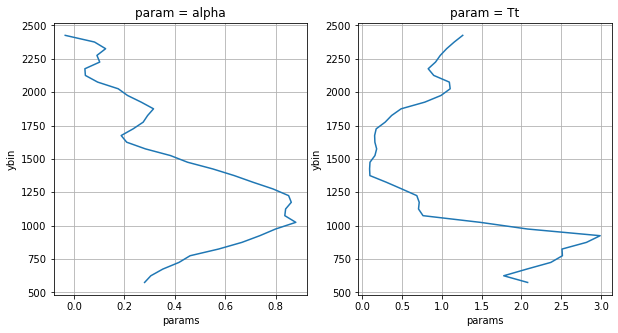

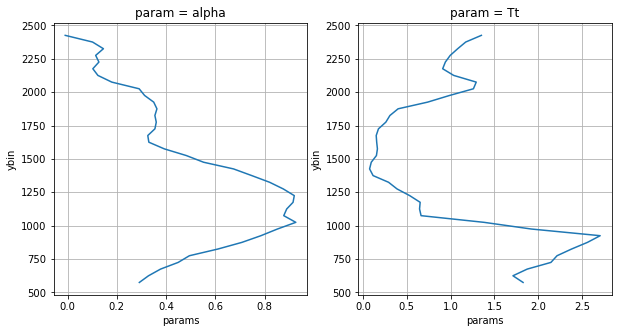

In [29]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
ax = axes[0]
(fit_E_alpha['uu'].sel(param='alpha').params-fit_L_alpha['uu'].sel(param='alpha').params).plot(y='ybin',ax=ax)
ax.grid()
ax=axes[1]
(fit_L_alpha['uu'].sel(param='Tt').params/fit_E_alpha['uu'].sel(param='Tt').params).plot(ax=ax,y='ybin')
ax.grid()


fig,axes = plt.subplots(1,2,figsize=(10,5))
ax = axes[0]
(fit_E_alpha['vv'].sel(param='alpha').params-fit_L_alpha['vv'].sel(param='alpha').params).plot(y='ybin',ax=ax)
ax.grid()
ax=axes[1]
(fit_L_alpha['vv'].sel(param='Tt').params/fit_E_alpha['vv'].sel(param='Tt').params).plot(ax=ax,y='ybin')
ax.grid()

In [30]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
